In [1]:
"""
Magic commands
"""
%matplotlib inline
%load_ext autoreload
%autoreload 2

"""
Python standard packages
"""
import os
import sys

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output

import scipy.stats as stats
import random

"""
Own packages
"""
sys.path.insert(0, "C:\\code\\speciale\\") # vesl path
sys.path.insert(0, "C:\\Users\\lucas\\OneDrive\\Skrivebord\\repo\\speciale\\") # ljb path

from market_simulation_study.agent import RandomAgent, InvestorAgent, TrendAgent, RLAgent, MarketMakerAgent
from market_simulation_study.agent import Memory, ActionValueNetwork, GaussianPolicyNetwork, ActorCriticAgent
from market_simulation_study.environment import MarketEnvironment

from torch.optim import Adam


"""
Initializations
"""
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)
sns.set_style("whitegrid")

# Simulation 


## Setup

In [2]:
# Declare parameters
n_random_agents = 20
n_investor_agents = 1
n_trend_agents = 5
n_mm_agents = 20
n_rl_agents = 1

n_agents = n_random_agents + n_investor_agents + n_trend_agents + n_rl_agents + n_mm_agents

price_list = [100 + np.random.normal() for j in range(100)]
volume = 0
fee = 0
slippage = 0
mean_buy_price = 99
mean_sell_price = 101
delta = 1

state0 = {"market_prices": price_list, "volume": volume, 'fee': fee, "mean_buy_price": mean_buy_price,
          "mean_sell_price": mean_sell_price, 'slippage': slippage}

agents = []

random_agents = [RandomAgent(agent_id = j,
                             delta = delta) for j in range(n_random_agents)]

investor_agents = [InvestorAgent(agent_id = j + n_random_agents,
                                 delta = 0.1,
                                 intensity = 0.01,
                                 price_margin = 0.01) for j in range(n_investor_agents)]

trend_agents = [TrendAgent(agent_id = j + n_random_agents + n_investor_agents,
                                 delta = delta) for j in range(n_trend_agents)]

mm_agents = [MarketMakerAgent(agent_id = j + n_random_agents + n_investor_agents + n_trend_agents,
                              delta = delta,
                              gamma = 0.01,
                             gamma2 = 1) for j in range(n_mm_agents)]

#rl_agents = [RLAgent(agent_id = j + n_random_agents + n_investor_agents + n_trend_agents + n_mm_agents,
#                                 delta = delta) for j in range(n_rl_agents)]

agents.append(investor_agents)
agents.append(random_agents)
agents.append(trend_agents)
agents.append(mm_agents)
#agents.append(rl_agents)


## Create Actor Critic Agent

In [3]:
#####################
# PARAMETERS
#####################
"""Neural Networks"""
max_action_value = 1.5  # Prices
min_action_value = 0.5  # Prices
max_action_value_two = 15  # Volumes
min_action_value_two = 0  # Volumes

action_dims = 4
state_dims = 7
fc1_dims = 256
fc2_dims = 256
learning_rate = 3e-4

batch_size = 5
n_gradient_steps_per_update = 1

"""RL Agent"""
discount_factor = 0.95
agent_id = n_random_agents + n_investor_agents + n_trend_agents + n_mm_agents
######################
# AGENT INITIALIZATION
######################
policy = GaussianPolicyNetwork(max_action_value     = max_action_value,
                               min_action_value     = min_action_value,
                               max_action_value_two = max_action_value_two,
                               min_action_value_two = min_action_value_two,
                               input_dims           = state_dims,
                               action_dims          = action_dims,
                               fc1_dims             = fc1_dims,
                               fc2_dims             = fc2_dims)

policy_optimiser = Adam(policy.parameters(), lr = learning_rate)

qf = ActionValueNetwork(input_dims = state_dims + action_dims,
                        fc1_dims = fc1_dims,
                       fc2_dims = fc2_dims)
qf_optimiser = Adam(qf.parameters(), lr = learning_rate)

vf = ActionValueNetwork(input_dims = state_dims)
vf_optimiser = Adam(vf.parameters(), lr = learning_rate)

rl_agents = [ActorCriticAgent(policy           = policy, 
                              policy_optimiser = policy_optimiser,
                              qf               = qf,
                              qf_optimiser     = qf_optimiser,
                              vf               = vf,
                              vf_optimiser     = vf_optimiser, 
                              discount_factor  = discount_factor, 
                              agent_id         = agent_id,
                              init_state       = state0,
                              batch_size       = batch_size)]

agents.append(rl_agents)

## Initialize agents from state0

In [4]:
agents = [item for sublist in agents for item in sublist]

#agents[-1].state_feature = agents[-1].get_state_features(state0)  # Initialize state_features

# Run Simulation with RL

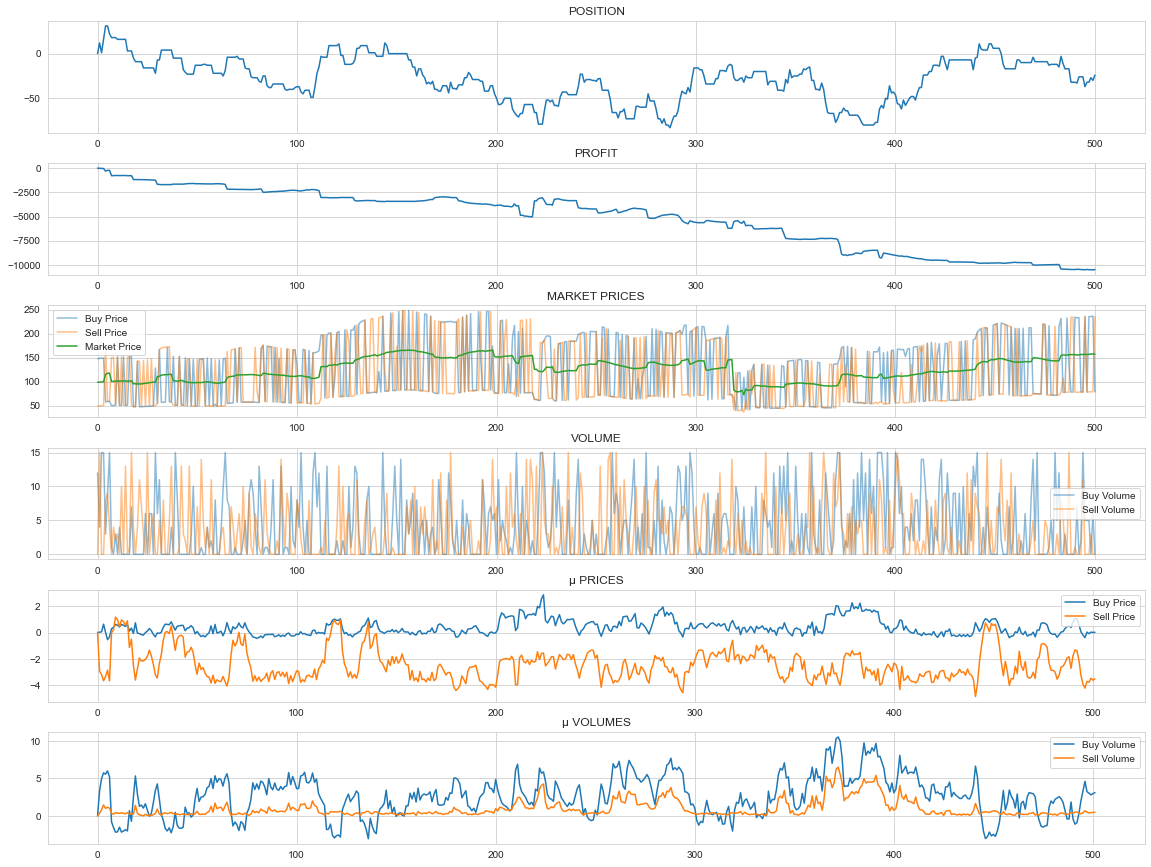

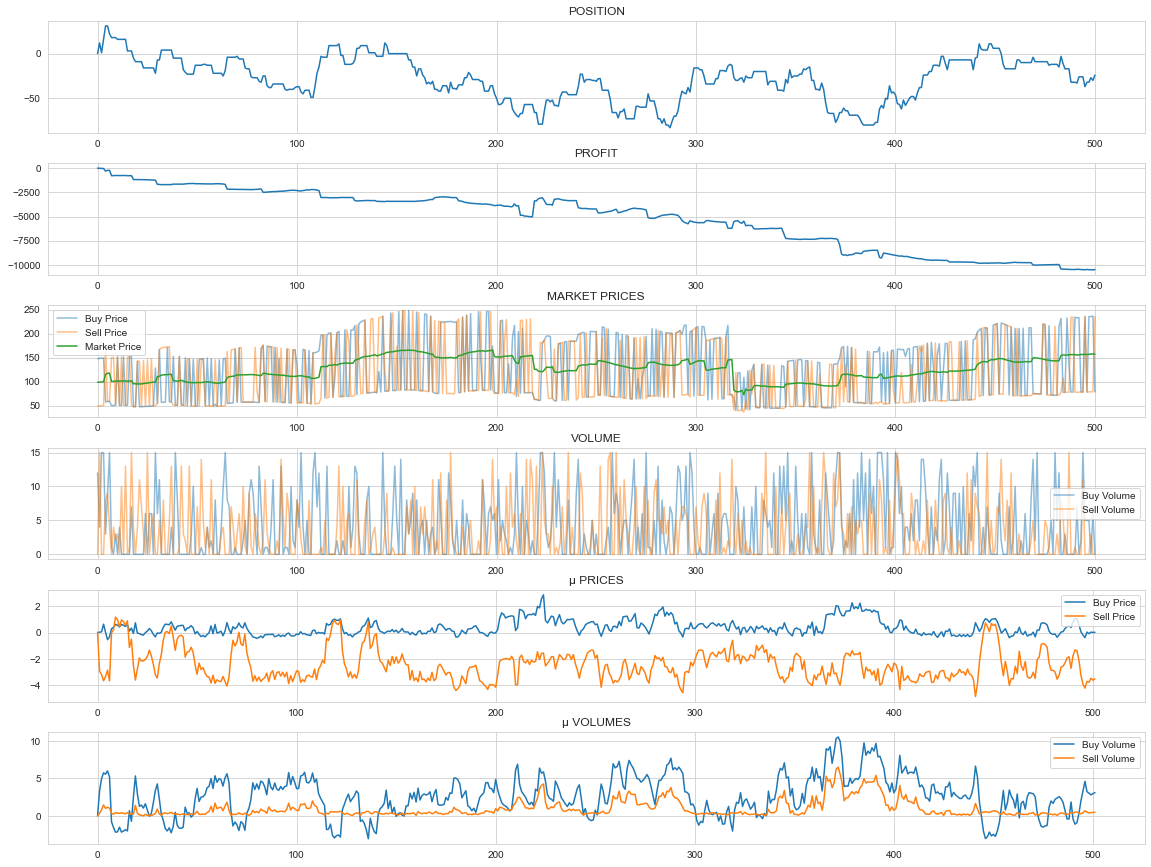

In [37]:
n_episodes = 30
time_periods = 501


fig, ax = plt.subplots(6, 1, figsize = (16, 12))
fig.tight_layout()

#################################
# START SIMULATION
#################################

for episode in range(n_episodes):
    
    #################################
    # NEW EPISODE
    #################################

    agents[-1].reset()
    env = MarketEnvironment(state0)
    for j in range(n_agents): # Initialize agents
            agents[j].update(state0)

    rl_profit = []
    rl_positions = []
    agent_class = []
    rl_buy_prices = []
    rl_sell_prices = []
    rl_buy_volume = []
    rl_sell_volume = []
    market_prices = []
    mus = np.array([[0, 0, 0, 0]])
    for time in range(time_periods):
        agents, state = env.step(agents)
        for j in range(n_agents-1):
            agents[j].update(state)

        #################################
        # RL AGENT UPDATE
        #################################
        if time < 0:
            agents[-1].update(state, exploration_mode = True)
        else:
            agents[-1].update(state, exploration_mode = False)

        if time >= 200:
            if time % 10 == 0:
                for _ in range(n_gradient_steps_per_update):
                    agents[-1].score_gradient_descent()

        # Store RL DATA
        agent_class.append(agents[-1].agent_class)
        rl_profit.append(agents[-1].pnl)
        rl_positions.append(agents[-1].position)
        rl_sell_prices.append(agents[-1].sell_price)
        rl_buy_prices.append(agents[-1].buy_price)
        rl_sell_volume.append(agents[-1].sell_volume)
        rl_buy_volume.append(agents[-1].buy_volume)
        market_prices.append(state["market_prices"][-1])
        
        # mus
        #mus.append([agents[-1].mu1, agents[-1].mu2, agents[-1].mu3, agents[-1].mu4])
        mus = np.vstack((mus, [agents[-1].mu1.detach().numpy(), agents[-1].mu2.detach().numpy(), agents[-1].mu3.detach().numpy(), agents[-1].mu4.detach().numpy()]))
        
        #################################
        # Print remaining runtime
        #################################
        j = (time + 1) / time_periods
        sys.stdout.write('\r'.center(65))
        sys.stdout.write(f"EPISODE {episode} - %d%%".center(65) % (100*j))
        sys.stdout.flush()

        
        #################################
        # VISUALISATION
        #################################
        
        if time % 100 == 0:
            clear_output()
            ax[0].cla()
            ax[0].plot(rl_positions, label = "Positions")
            ax[0].set(title = "POSITION")
            
            ax[1].cla()
            ax[1].set(title = "PROFIT")
            ax[1].plot(rl_profit, label = "Profit")

            ax[2].cla()
            ax[2].plot(rl_buy_prices, label = "Buy Price", alpha = 0.5)
            ax[2].plot(rl_sell_prices, label = "Sell Price", alpha = 0.5)
            ax[2].plot(state["market_prices"][100:], label = "Market Price")
            ax[2].set(title = "MARKET PRICES")
            ax[2].legend()
            
            ax[3].cla()
            ax[3].plot(rl_buy_volume, label = "Buy Volume", alpha = 0.5)
            ax[3].plot(rl_sell_volume, label = "Sell Volume", alpha = 0.5)
            ax[3].set(title = "VOLUME")
            ax[3].legend()
            
            ax[4].cla()
            labs = ["Buy Price", "Sell Price"]
            for i in range(2):    
                ax[4].plot(mus[:, i], label = labs[i])
            ax[4].set(title = "µ PRICES")
            ax[4].legend()
            
            ax[5].cla()
            labs2 = ["Buy Volume", "Sell Volume"]
            for j in range(2):
                ax[5].plot(mus[:, 2 + j], label = labs2[j])
            ax[5].legend()
            ax[5].set(title = "µ VOLUMES")
            display(fig)
        

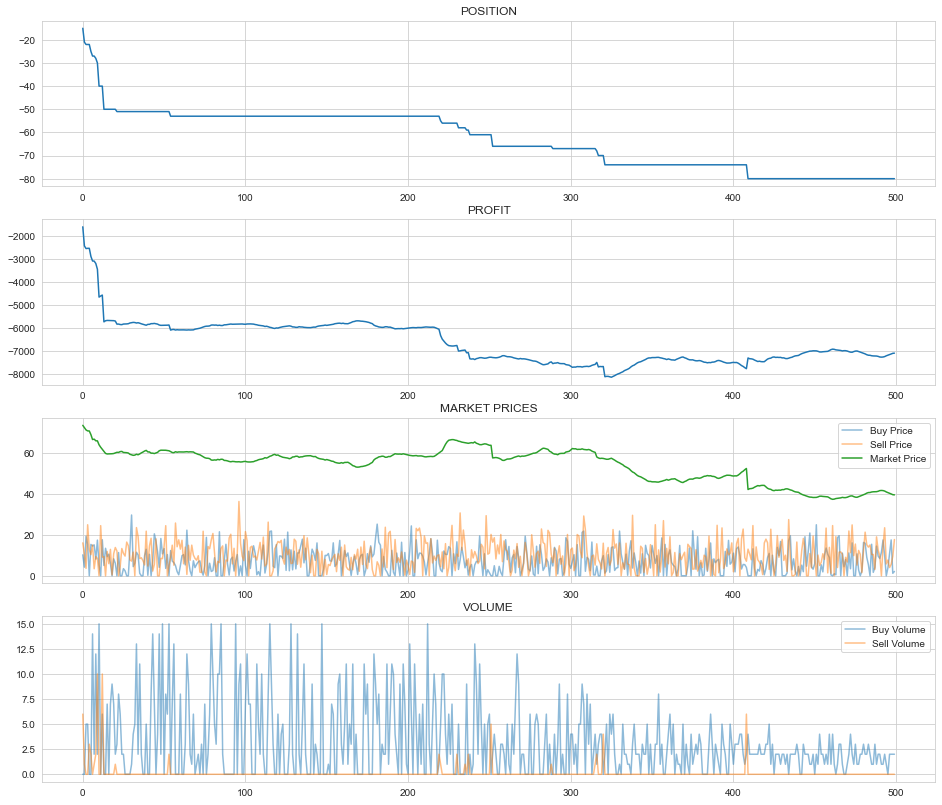

In [29]:
fig, ax = plt.subplots(4, 1, figsize = (16, 14))
ax[0].plot(rl_positions, label = "Positions")
ax[0].set(title = "POSITION")
ax[1].set(title = "PROFIT")
ax[1].plot(rl_profit, label = "Profit")


ax[2].plot(rl_buy_prices, label = "Buy Price", alpha = 0.5)
ax[2].plot(rl_sell_prices, label = "Sell Price", alpha = 0.5)
ax[2].plot(state["market_prices"][100:], label = "Market Price")
ax[2].set(title = "MARKET PRICES")
ax[2].legend()

ax[3].plot(rl_buy_volume, label = "Buy Volume", alpha = 0.5)
ax[3].plot(rl_sell_volume, label = "Sell Volume", alpha = 0.5)
ax[3].set(title = "VOLUME")
ax[3].legend()

[Text(0.5, 1.0, 'Cumulative Returns')]

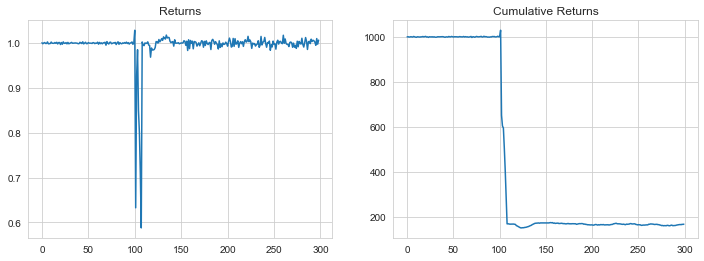

In [9]:
mp = pd.DataFrame(state['market_prices'])
#returns = mp / mp.shift(1)  - 1
returns = np.array(state["market_prices"][1:]) / np.array(state["market_prices"][:-1]) 
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(returns)
ax[0].set(title = "Returns")
ax[1].plot(mp)
ax[1].set(title = "Cumulative Returns")
#plt.savefig("plots/returns_cumreturns.png")

In [13]:
def weighted_mean(var, wts):
    """Calculates the weighted mean"""
    return np.average(var, weights=wts)


def weighted_variance(var, wts):
    """Calculates the weighted variance"""
    return np.average((var - weighted_mean(var, wts))**2, weights=wts)

def weighted_skew(var, wts):
    """Calculates the weighted skewness"""
    return (np.average((var - weighted_mean(var, wts))**3, weights=wts) /
            weighted_variance(var, wts)**(1.5))

def weighted_kurtosis(var, wts):
    """Calculates the weighted skewness"""
    return (np.average((var - weighted_mean(var, wts))**4, weights=wts) /
            weighted_variance(var, wts)**(2))

KeyboardInterrupt: 

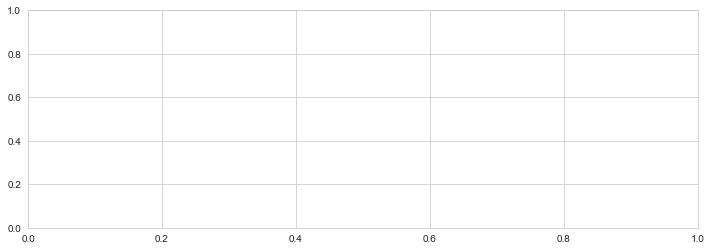

In [18]:
avg = np.nanmean(returns)
std = np.std(returns)
n = len(returns)
x = np.linspace(np.max(returns), np.min(returns), n)
norm_dist = stats.norm.pdf(x, avg, std)
kurt = weighted_kurtosis(returns[1:], wts = np.ones_like(returns[1:]))
skew = weighted_skew(returns[1:], wts = np.ones_like(returns[1:]))
fig, ax = plt.subplots( figsize = (12, 4))

sns.histplot(returns, stat = "density", label = "Returns", ax = ax)
ax.plot(x, norm_dist, label = "Normal dist", ls = "--", color = "red", lw = 1)
ax.legend()
ax.set(title = "Return dist vs Normal Dist", xlim = (-0.05, 0.05))
ax.text(-0.04, 55, f"kurt = {kurt:.1f}", fontsize = 15)
ax.text(-0.04, 45, f"skew = {skew:.1f}", fontsize = 15)
#

plt.savefig("plots/kurtosis_dist.png")

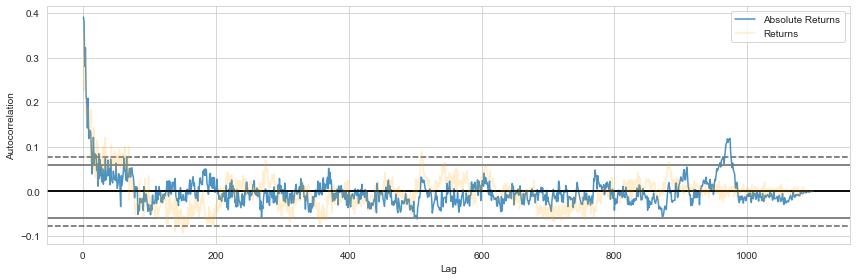

In [13]:

fig, ax = plt.subplots( figsize = (12, 4))

pd.plotting.autocorrelation_plot(np.abs(returns[1:]), ax = ax, label = "Absolute Returns", alpha = 0.8)
pd.plotting.autocorrelation_plot(returns[1:], ax = ax, color = "orange", alpha = 0.2, label = "Returns")
fig.tight_layout()
#plt.savefig("plots/autocorel.png")

# Performance overview

In [11]:
stats_df = pd.DataFrame({"id":None, "class":None, "Position":None, "PNL":None}, index = [0]).dropna()
for agent in agents:
    agent.calculate_profit_and_loss(state)
    df_temp = pd.DataFrame({"id": agent.agent_id,
                            "class":agent.agent_class, 
                            "Position":agent.position, 
                            "PNL": agent.pnl, 
                            "latency": agent.latency},
                            index = [agent.agent_id])
    stats_df = stats_df.append(df_temp)

print("PNL SUM: ", stats_df["PNL"].sum())
print("POS SUM: ", stats_df["Position"].sum())
stats_df.sort_values("latency", inplace = True)
np.corrcoef(stats_df.PNL.values, stats_df.latency.values)
display(stats_df)
display(stats_df.groupby("class")["PNL"].mean())

PNL SUM:  -5.4569682106375694e-12
POS SUM:  0.0


,id,class,Position,PNL,latency
39,39,MM,15.0,-140.058136,0.528552
36,36,MM,9.0,-123.701191,0.536305
46,46,ActorCritic,-446.0,-13735.601703,0.545926
44,44,MM,10.0,-114.708676,0.576591
38,38,MM,12.0,-133.692593,0.600671
37,37,MM,5.0,-25.436167,0.714622
45,45,MM,10.0,-1.444297,0.738242
42,42,MM,12.0,-347.515008,0.756687
40,40,MM,10.0,39.188800,0.869438
41,41,MM,11.0,-11.024922,0.928084


class
ActorCritic   -13735.601703
Investor        4259.795382
MM               -83.313463
Random           411.212833
Trend           -405.488805
Name: PNL, dtype: float64